In [1]:
%matplotlib notebook
#import matplotlib.pyplot as plt
#import numpy as np
import urllib.request
import gzip
import os

def load_covtype_dataset():
    '''Downloads the Cover Type dataset from UCI repository, returning a file handle'''
    CURRENT_DIR = os.getcwd()
    COVTYPE_FILENAME = 'covtype.data'
    COVTYPE_DATA_PATH = os.path.join(CURRENT_DIR, COVTYPE_FILENAME)
    COVTYPE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
    if os.path.isfile(COVTYPE_DATA_PATH):
        print('Using local cached copy in', COVTYPE_DATA_PATH)
    else:
        print('Dataset not found locally. Downloading in', COVTYPE_DATA_PATH)
        with urllib.request.urlopen(COVTYPE_URL) as response:
            with gzip.GzipFile(fileobj=response) as uncompressed, open(COVTYPE_DATA_PATH, 'wb') as out_file:
                file_header = uncompressed.read()
                out_file.write(file_header)
    return COVTYPE_DATA_PATH


In [2]:
covtype_file = load_covtype_dataset()

Using local cached copy in /tf/notebook/covtype.data


In [3]:
import pandas as pd
import numpy as np

df_covtype = pd.read_csv(covtype_file, header=None)

In [4]:
df_covtype.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [5]:
def features_renaming(df_covtype):
    '''Rename each column to meaningful labels'''
    # First step: rename the first 14 columns
    first_fourteen_old_feature_names = df_covtype.columns[np.arange(0,14)]
    first_fourteen_new_feature_names = ['Elevation', 'Aspect', 'Slope',
                                        'Horizontal_Distance_To_Hydrology',
                                        'Vertical_Distance_To_Hydrology',
                                        'Horizontal_Distance_To_Roadways',
                                        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                                        'Horizontal_Distance_To_Fire_Points',
                                        'Wilderness_Area_1', 'Wilderness_Area_2',
                                        'Wilderness_Area_3', 'Wilderness_Area_4']
    old_to_new_name_mapping = dict(zip(first_fourteen_old_feature_names, first_fourteen_new_feature_names))
    df_covtype.rename(columns=old_to_new_name_mapping, inplace=True)
    # Second step: rename the 40 soil type columns
    soil_type_old_feature_names = df_covtype.columns[np.arange(14,54)]
    soil_type_new_feature_names = ['Soil_Type_' + str(i) for i in np.arange(1,41)]
    old_to_new_name_mapping = dict(zip(soil_type_old_feature_names, soil_type_new_feature_names))
    df_covtype.rename(columns=old_to_new_name_mapping, inplace=True)
    # Last step: rename the last feature (cover type)
    df_covtype.rename(columns={54: 'Cover_Type'}, inplace=True)
    return df_covtype

In [6]:
# Features names are numeric, let's rename each one of them
df_covtype = features_renaming(df_covtype)

In [7]:
df_covtype.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [8]:
# Check the number of samples for each class value
df_covtype.Cover_Type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

In [9]:
# Let's copy the first 15120 rows onto a new df and
# perform some Exploratory Data Analysis (EDA)
train = df_covtype[:15120].copy()

In [10]:
# Check if stratified sampling has already been done for the training set (it has)
train.Cover_Type.value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def elevation_multiple_covtype_distplot(elevations_df, covtype_mapping):
    '''Plot an Elevation's histogram for each Cover Type on the same figure'''
    # Color palette for distplot
    custom_palette = ['#F97EDB', '#49C0EA', '#B49EFC', '#CDAB40',
                      '#F69089', '#76BF3F', '#4CC9A6']
    # Set distplot background
    sns.set_style('darkgrid')
    # Custom bins range for evenly spaced hists
    bins = range(1800,4000,60)
    # Iterate through the dictionary to plot a histogram for each cover type
    for covtype_id, covtype_name in covtype_mapping.items():
        # covtype_id goes from 1 to 7
        # thus subtract 1 for indexing custom_palette
        palette_idx = covtype_id - 1        
        # Create a group for each Cover_Type and return a df satisfying the condition
        # on Cover_Type column
        by_one_covtype = elevations_df.groupby('Cover_Type') \
                                      .apply(lambda x: x[ x['Cover_Type'] == covtype_id ])
        # Plot one Elevation histogram for one group
        ax = sns.distplot(by_one_covtype.Elevation,
                          bins=bins,
                          color=custom_palette[palette_idx], label=covtype_name,
                          hist_kws=dict(alpha=0.8, edgecolor="none"),
                          kde=False)

    # Legend position to upper right
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.8), ncol=1)
    # Apply proper labeling to the axes
    ax.set(xlabel='Elevation (meters)', ylabel='Count')
    # Avoid cutting off the legend from the figure
    plt.tight_layout()
    # Show the figure (can be omitted in Jupyter Notebooks)
    plt.show()

<IPython.core.display.Javascript object>


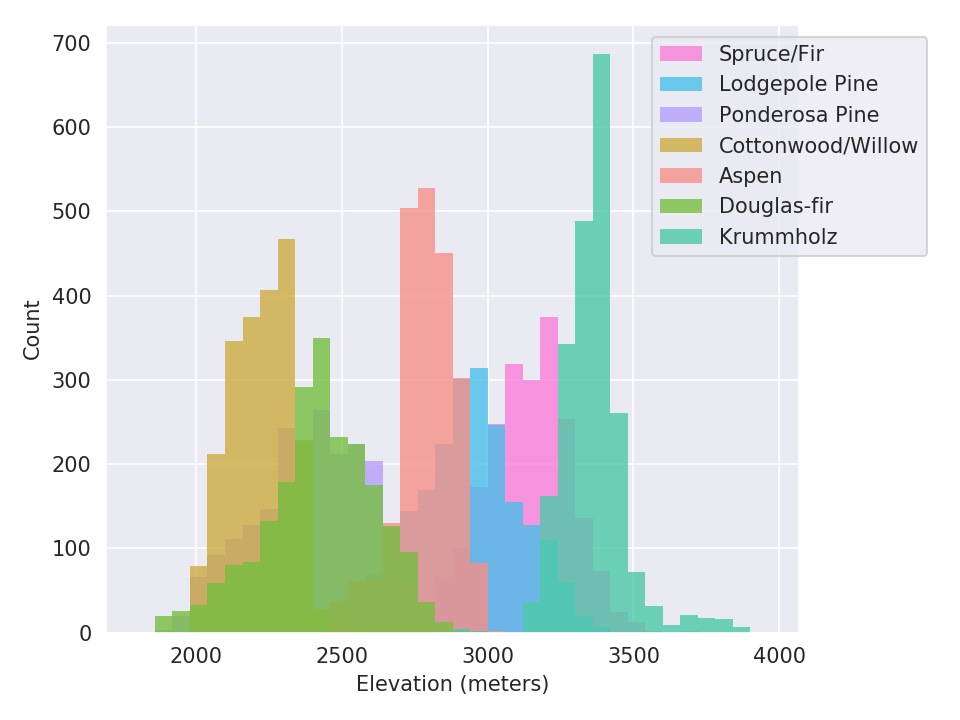

In [12]:
# Plot an Elevation's histogram for each Cover Type
# to check for possible class separation

# Slice by two columns: Elevation and Cover_Type
elevations = train.loc[:, ['Elevation', 'Cover_Type']]
# Dictionary for mapping each integer target label to its string value
covtype_label_name_dict = {1: 'Spruce/Fir',
                           2: 'Lodgepole Pine',
                           3: 'Ponderosa Pine',
                           4: 'Cottonwood/Willow',
                           5: 'Aspen',
                           6: 'Douglas-fir',
                           7: 'Krummholz'}
# It is clear that classes
# 4 (Willow), 5 (Aspen) and 7 (Krummholz) are easily separable
elevation_multiple_covtype_distplot(elevations, covtype_label_name_dict)

In [13]:
# Don't need elevations anymore
print('Dereferencing elevations')
del elevations

Dereferencing elevations


<IPython.core.display.Javascript object>


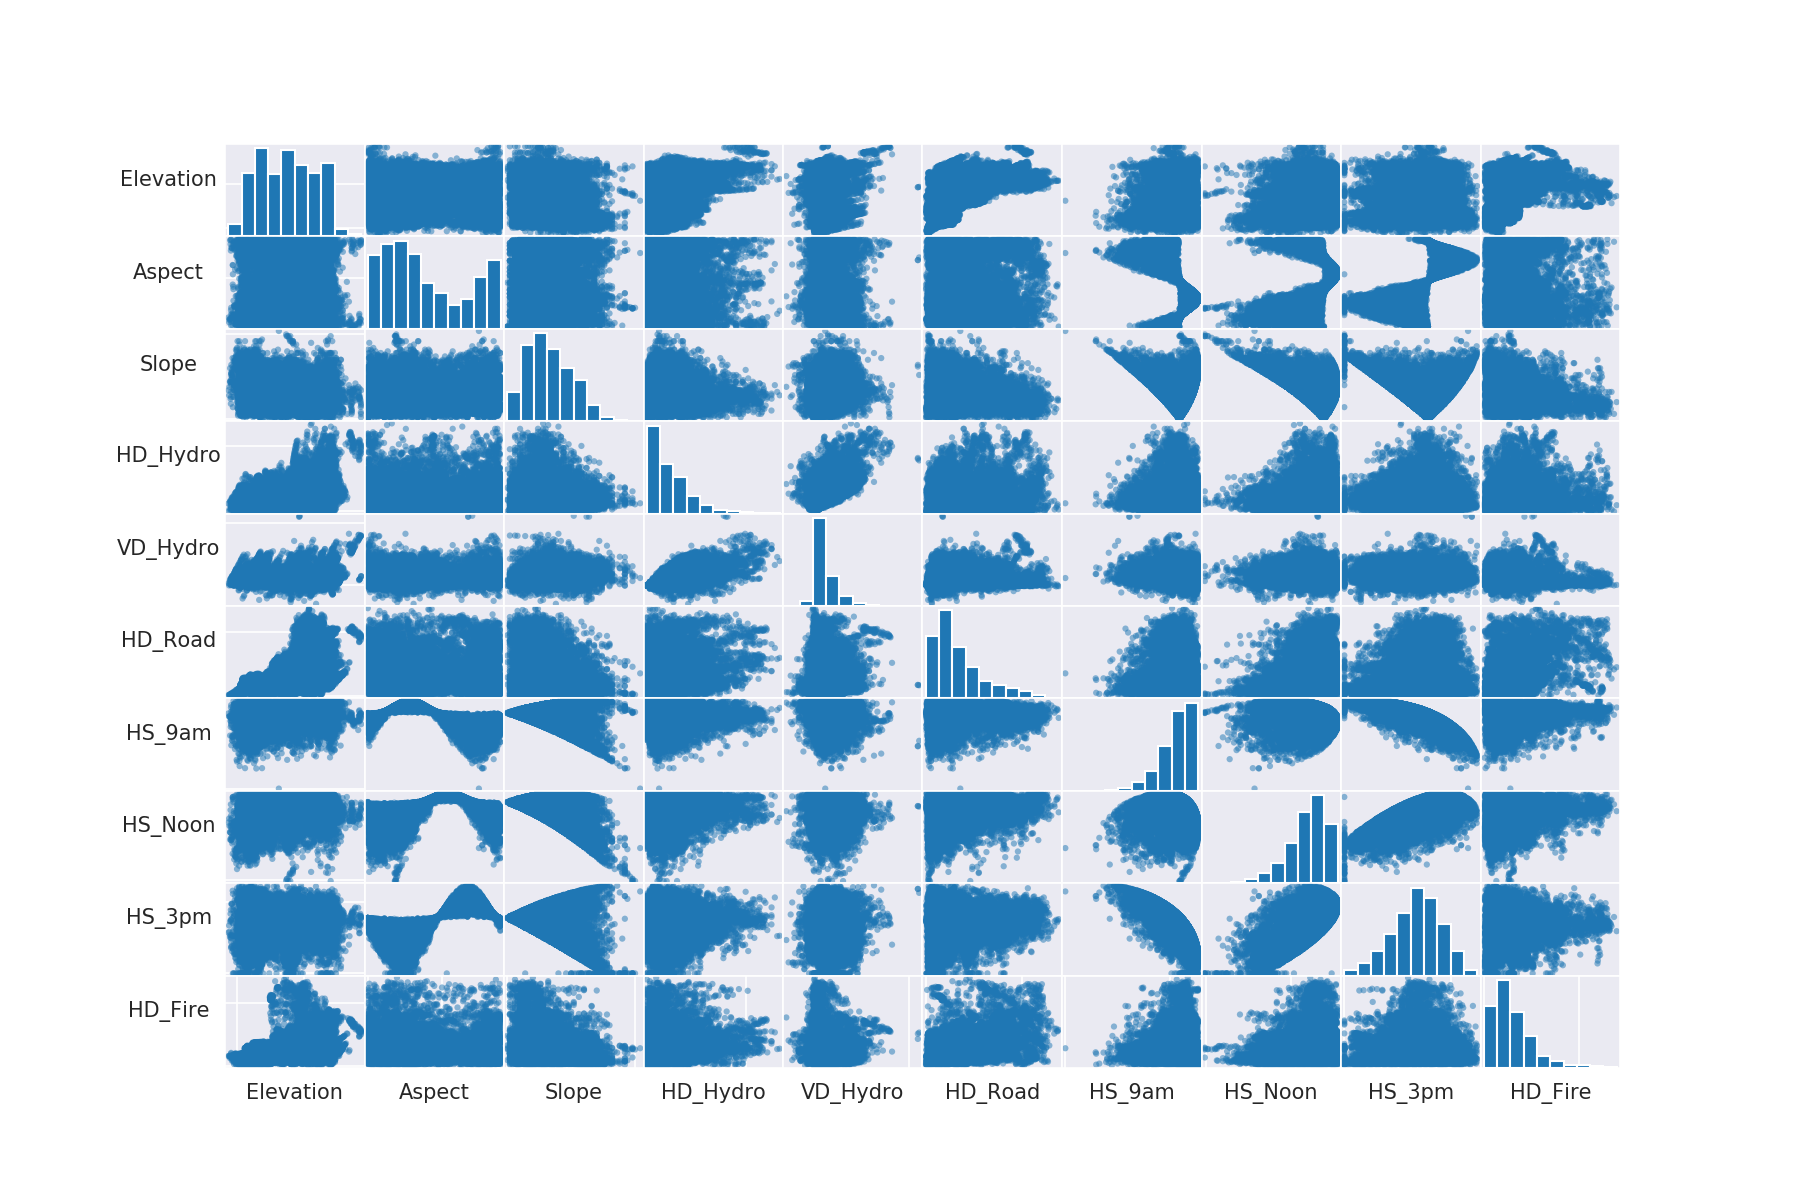

In [14]:
# Since the Elevation looks like a promising feature for Cover Type prediction
# let's check the correlation matrix to see which continuos feature
# depends on the Elevation
# Note that we could have used Chi-Squared Test to check for features
# dependency on Cover Type but it is out of scope for this project
from pandas.plotting import scatter_matrix

# The features we are interested in for the correlation matrix
features_to_check = ['Elevation', 'Aspect',
                     'Slope',
                     'Horizontal_Distance_To_Hydrology',
                     'Vertical_Distance_To_Hydrology',
                     'Horizontal_Distance_To_Roadways',
                     'Hillshade_9am', 'Hillshade_Noon',
                     'Hillshade_3pm',
                     'Horizontal_Distance_To_Fire_Points']
# Same features as above, just with some shorter names
# for visualization purposes
labels_to_plot = ['Elevation', 'Aspect',
                  'Slope', 'HD_Hydro',
                  'VD_Hydro', 'HD_Road',
                  'HS_9am', 'HS_Noon',
                  'HS_3pm', 'HD_Fire']
# Create a dictionary for mapping the labels like this
# {long_label: short_label}
shorter_labels = dict(zip(features_to_check, labels_to_plot))
# Make a copy of the training set because we want to rename
# some columns to fit them on the graph
corr_train = train[features_to_check].copy()
# Do the renaming feeding the mapping dictionary we created
corr_train.rename(columns=shorter_labels, inplace=True)
# Grab the AxesSubplots handle to modify labels padding and rotation
axes = scatter_matrix(corr_train, figsize=(12, 8))
n = len(corr_train.columns)
for x in range(n):
    for y in range(n):
        # for all the axes on the graph..
        ax = axes[x,y]
        # rotate the y-axis labels by 0 (horizontally)..
        ax.yaxis.label.set_rotation(0)
        # add some padding between the labels and their subgraph..
        ax.xaxis.labelpad = 0
        ax.yaxis.labelpad = 20
        # and hide axes value ranges
        ax.set_yticklabels([])
        ax.set_xticklabels([])

<IPython.core.display.Javascript object>


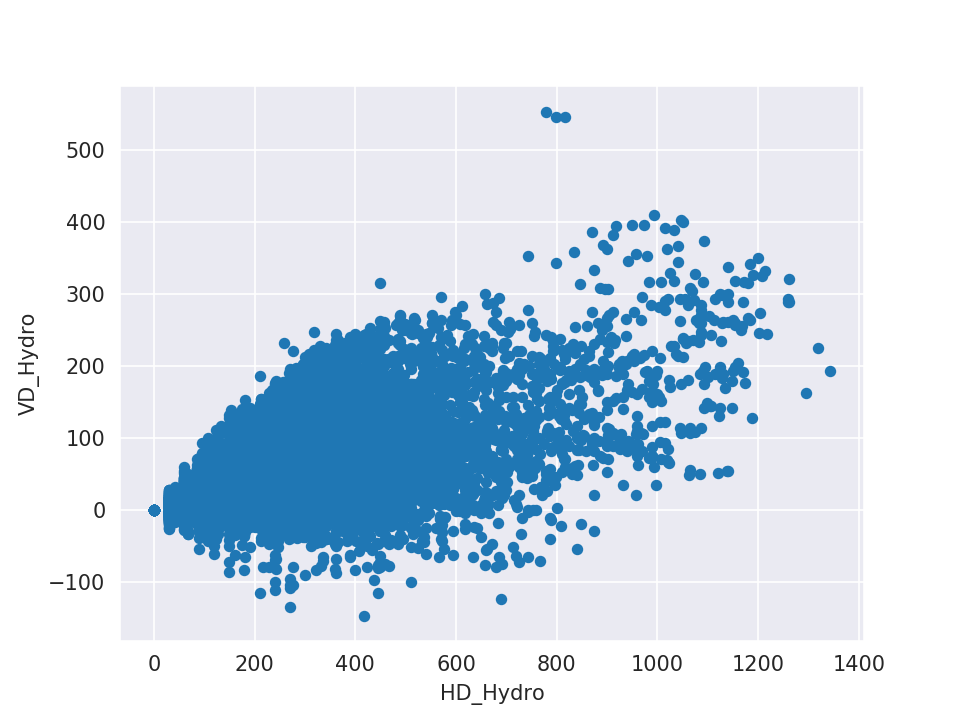

In [15]:
# Let's write down the most correlated features:
# - 'HD_Hydro' and 'VD_Hydro'
# - 'HS_Noon' and 'HS_3pm'
# Plot the same scatter graph zooming on these
corr_train.plot(kind='scatter', x='HD_Hydro', y='VD_Hydro')

<IPython.core.display.Javascript object>


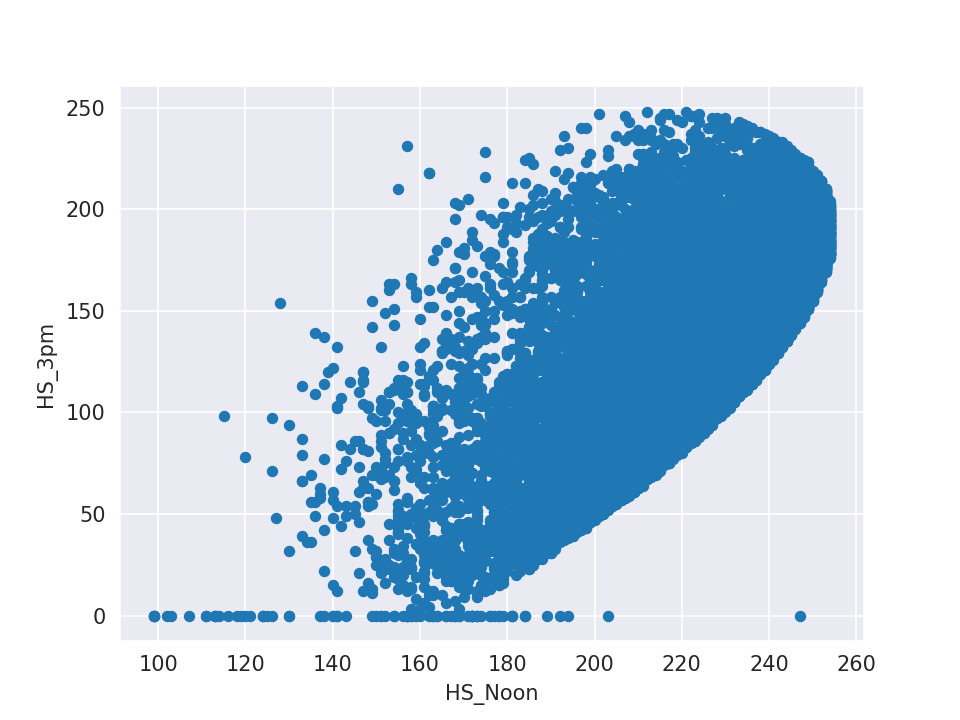

In [16]:
# Looks like there are a lot of HS_3pm equal to zero.
# It could help to impute those with the median
corr_train.plot(kind='scatter', x='HS_Noon', y='HS_3pm')

In [17]:
# Don't need corr_train df anymore
# Hopefully the garbage collector will clean it up
print('Dereferencing corr_train')
del corr_train

Dereferencing corr_train


In [18]:
# Count Hillshade_3pm zeros on the training set
(train.Hillshade_3pm == 0).astype(int).sum(axis=0)

88

In [19]:
# Imputing Hillshade_3pm zeros with the median
from sklearn.impute import SimpleImputer

simp = SimpleImputer(missing_values=0, strategy='median')
# fit_transform requires X as a numpy array of shape [n_samples, n_features]
# thus the dataframe column is casted to a numpy array and reshaped
train.Hillshade_3pm = simp.fit_transform(train.Hillshade_3pm.values.reshape(-1,1))
# Count the zeros again to check the result
(train.Hillshade_3pm == 0).astype(int).sum(axis=0)

0

In [20]:
# Drop the training set from df_covtype
df_covtype = df_covtype.iloc[15120:]
# Append the imputed training set to df_covtype
df_covtype = pd.concat([train, df_covtype])

In [21]:
# Don't need train df anymore
del train

In [22]:
# Let's compute the Euclidean distance to Hydrology
hv_distances_labels = ['Horizontal_Distance_To_Hydrology',
                       'Vertical_Distance_To_Hydrology']
hv_dist_hydro_arr = df_covtype[hv_distances_labels].values
# Perform the Euclidean distance with respect to the origin
# (i.e (0;0) where the water is located)
euc_distance_to_hydro = np.linalg.norm(hv_dist_hydro_arr, axis=1)
# Add the new feature 'Distance_To_Hydrology' to the training set
# just after the 'Slope' feature at index 2
# rounding each distance to four decimal places
df_covtype.insert(3,
                  'Distance_To_Hydrology',
                  np.around(euc_distance_to_hydro, decimals=4))
# Drop the horizontal and vertical distance
df_covtype.drop(columns=hv_distances_labels, inplace=True)

In [23]:
# Check the result
df_covtype.head(2)

,Elevation,Aspect,Slope,Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_1,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258.0000,510,221,232,148.0,6279,1,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212.0849,390,220,235,151.0,6225,1,...,0,0,0,0,0,0,0,0,0,5


In [24]:
# Perform one hot encoding via get_dummies,
# then drop the integer target label, leaving the one hot encoded labels only
one_hot_covtype = pd.get_dummies(df_covtype.Cover_Type, prefix='CovT')
df_covtype.drop(columns='Cover_Type', inplace=True)
df_covtype_ohe = df_covtype.join(one_hot_covtype)

In [25]:
# Check the resulting shape
df_covtype_ohe.shape

(581012, 60)

In [26]:
# Don't need df_covtype anymore
print('Dereferencing df_covtype')
del df_covtype

Dereferencing df_covtype


In [27]:
# Downcast all features to reduce the overall dataframe dimension

# Get the columns header onto a list
df_covtype_ohe_headers = df_covtype_ohe.columns.values.tolist()
# There is no need to convert the last 7 elements, they are already uint8
# just drop them
df_covtype_ohe_headers = df_covtype_ohe_headers[:-7 or None]
# A list containing the new dtype for each column of interest
features_new_dtype_list = list()
# Iterate through the headers list to assign the new dtype
# for each column
for i in range(len(df_covtype_ohe_headers)):
    if i == 3:
        # Distance_To_Hydrology could fit in float16
        # but float32 works better with mean and std calculations
        features_new_dtype_list.append('float32')
    elif i < 9:
        # First nine features except Distance_To_Hydrology
        # can have int16
        features_new_dtype_list.append('int16')
    else:
        # the remaining ones are binary integers, so uint8
        # is enough
        features_new_dtype_list.append('uint8')
# A dictionary whose keys are the dataframe columns and values
# are the new dtype ( namely, {'Elevation' : 'int16', ...} )
features_new_dtype_mapping = dict(zip(df_covtype_ohe_headers,
                                      features_new_dtype_list))
# Perform the downcasting using the dictionary just created
df_covtype_ohe = df_covtype_ohe.astype(dtype=features_new_dtype_mapping)

In [28]:
# Check the result
df_covtype_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 60 columns):
Elevation                             581012 non-null int16
Aspect                                581012 non-null int16
Slope                                 581012 non-null int16
Distance_To_Hydrology                 581012 non-null float32
Horizontal_Distance_To_Roadways       581012 non-null int16
Hillshade_9am                         581012 non-null int16
Hillshade_Noon                        581012 non-null int16
Hillshade_3pm                         581012 non-null int16
Horizontal_Distance_To_Fire_Points    581012 non-null int16
Wilderness_Area_1                     581012 non-null uint8
Wilderness_Area_2                     581012 non-null uint8
Wilderness_Area_3                     581012 non-null uint8
Wilderness_Area_4                     581012 non-null uint8
Soil_Type_1                           581012 non-null uint8
Soil_Type_2                           581012 no

In [29]:
# Drop Aspect and Slope since working with angles is tricky
# when computing the mean
df_covtype_ohe.drop(labels=['Aspect', 'Slope'], axis=1, inplace=True)

In [30]:
def train_test_split(df_covtype_ohe):
    '''
    Split the one hot encoded dataset onto training set and test set
    according to UCI's repository guidelines
    '''
    # First 15120 rows for the training set
    X_train = df_covtype_ohe[:15120].copy()
    # The last seven colums are the targets
    X_train, y_train = X_train.iloc[:, :51], X_train.iloc[:, 51:]
    # The remaining rows are for the test set
    X_test = df_covtype_ohe[15121:].copy()
    X_test, y_test = X_test.iloc[:, :51], X_test.iloc[:, 51:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(df_covtype_ohe)

In [31]:
# Check shapes consistency
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, ' \
      f'y_train: {y_train.shape}, y_test: {y_test.shape}')

X_train: (15120, 51), X_test: (565891, 51), y_train: (15120, 7), y_test: (565891, 7)


In [32]:
# Let's standardize the training set and test set.
# Note that we use the training set ONLY to calculate the mean and standard deviation
# then normalize the training set 
# and finally use the (training) mean and standard deviation to normalize the test set.
# This ensures no data leakage.

def train_test_normalize(X_train, X_test):
    '''
    Perform standardization on the training set and transforms the
    test set accordingly
    '''
    # The numerical columns we want to normalize
    numerical_columns = ['Elevation',
                         'Distance_To_Hydrology',
                         'Horizontal_Distance_To_Roadways',
                         'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                         'Horizontal_Distance_To_Fire_Points']
    # Calculate the mean and standard deviation of the training set
    X_train_num_cols_mean = X_train[numerical_columns].mean()
    X_train_num_cols_std = X_train[numerical_columns].std()
    # Perform standardization over the numerical columns of the training set
    X_train_std = (X_train[numerical_columns] - X_train_num_cols_mean) / X_train_num_cols_std
    # Concatenate side-by-side the normalized training set and the one-hot encoded features
    # Note that we index X_train dataframe by the (set) difference of the overall features
    # minus the numerical ones
    ohe_features = X_train.columns.difference(other=numerical_columns, sort=False)
    X_train_std = pd.concat([X_train_std, X_train[ohe_features]], axis=1)
    # Perform standardization over the numerical columns of the test set, using the mean and std
    # of the training set as discussed earlier
    X_test_std = (X_test[numerical_columns] - X_train_num_cols_mean) / X_train_num_cols_std
    # Concatenate side-by-side the normalized test set and the one-hot encoded features
    X_test_std = pd.concat([X_test_std, X_test[ohe_features]], axis=1)
    return X_train_std, X_test_std

X_train_std, X_test_std = train_test_normalize(X_train, X_test)

In [33]:
# Generate one validation set from the normalized training set.
# Since the training set contains 2160 samples for each class,
# let's split according to 75% training set / 25% validation set.
# This yields 1620 samples for the new training set and 540 for the validation set.
# NOTE THAT WE ARE "RETURNING" NUMPY ARRAYS!

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
for train_index, valid_index in sss.split(X_train_std, y_train):
    X_train_std_minus_validation = X_train_std.iloc[train_index].to_numpy()
    X_validation = X_train_std.iloc[valid_index].to_numpy()
    y_train_minus_validation = y_train.iloc[train_index].to_numpy()
    y_validation = y_train.iloc[valid_index].to_numpy()

In [34]:
# Check shapes consistency
print(f'X_train_std w/o validation set: {X_train_std_minus_validation.shape} \n' \
      f'X_validation: {X_validation.shape} \n' \
      f'y_train w/o validation set: {y_train_minus_validation.shape} \n' \
      f'y_validation: {y_validation.shape}')

X_train_std w/o validation set: (11340, 51) 
X_validation: (3780, 51) 
y_train w/o validation set: (11340, 7) 
y_validation: (3780, 7)


In [44]:
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
from tensorflow import set_random_seed

# TODO: spostare i seeds nella prima cella del notebook
# numpy seed
seed(1)
# tf seed
set_random_seed(2)
n_features = X_train_std_minus_validation.shape[1]

classifier_net = keras.Sequential()
# Hidden layer
classifier_net.add(keras.layers.Dense(120, activation='relu', input_dim=n_features))
# Output layer
classifier_net.add(keras.layers.Dense(7, activation='softmax'))
classifier_net.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# Check the model architecture
classifier_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 120)               6240      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 847       
Total params: 7,087
Trainable params: 7,087
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Each bach is 10% (e.g. 1134) of the training set size (e.g. 11340)
# Train the network and test it against the validation set
clf_output = classifier_net.fit(X_train_std_minus_validation,
                                y_train_minus_validation,
                                epochs=2,
                                batch_size=1134,
                                shuffle=True,
                                validation_data=(X_validation, y_validation),
                                verbose=1)

Train on 11340 samples, validate on 3780 samples
Epoch 1/2
11340/11340 [==============================] - 0s 10us/sample - loss: 1.9612 - categorical_accuracy: 0.1804 - val_loss: 1.9382 - val_categorical_accuracy: 0.2135
Epoch 2/2
11340/11340 [==============================] - 0s 4us/sample - loss: 1.9255 - categorical_accuracy: 0.2230 - val_loss: 1.9042 - val_categorical_accuracy: 0.2558


In [46]:
# Verify classifier on the test set
# I'm using the validation here just for code testing purposes
# TODO: Remember to SUBSTITUTE X_validation with X_test
y_pred_validation = classifier_net.predict(X_validation)
# Reverse one-hot encoding (i.e going back to categorical variables)
# for the predicted targets
y_pred_validation_cat = np.argmax(y_pred_validation, axis=1)
# Do the same for the true targets
y_validation_cat = np.argmax(y_validation, axis=1)

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_validation_cat, y_pred_validation_cat)

In [48]:
print(cm)

[[239   0   1  76  31  44 149]
 [203   5   1 111  58  46 116]
 [205   2   2 186  62  75   8]
 [181   0   0 331  17  11   0]
 [255   1   2  80  81  71  50]
 [243   7   1 197  46  33  13]
 [210   0   0  20   3  31 276]]


import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(1)

class CovtypeDataset(TensorDataset):

    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(CovtypeDataset, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame()
        return torch.from_numpy(df.values).float()

train_data = CovtypeDataset(X_train_std, y_train)
test_data = CovtypeDataset(X_test_std, y_test)

batch_size = 15120
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print('# training samples:', len(train_data))
print('# batches:', len(train_loader))

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Classifier(nn.Module):

    def __init__(self, n_features, n_hidden=120, n_output=7, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.hidden = nn.Linear(n_features, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)
#        self.network = nn.Sequential(
#            # Input layer
#            nn.Linear(n_features, n_hidden),
#            # First hidden layer
#            nn.Sigmoid,
#            nn.Dropout(p_dropout),
#            # Output layer
#            nn.Sigmoid,
#            nn.Dropout(p_dropout),
#        )

    def forward(self, x):
        x = self.hidden(x)
        x = F.sigmoid(x)
        x = self.output(x)
        return x

clf = Classifier(n_features=X_train_std.shape[1])
clf_criterion = nn.MSELoss()
clf_optimizer = optim.SGD(clf.parameters(), lr=0.05, momentum=0.5)

# def pretrain_classifier(clf, data_loader, optimizer, criterion):
#     for x, y in data_loader:
#         clf.zero_grad()
#         p_y = clf(x)
#         loss = criterion(p_y, y)
#         loss.backward()
#         optimizer.step()
#     return clf


N_CLF_EPOCHS = 2

for epoch in range(N_CLF_EPOCHS):
    # clf = pretrain_classifier(clf, train_loader, clf_optimizer, clf_criterion)
    for x, y in train_loader:
        predicted_y = clf(x)
        loss = clf_criterion(predicted_y, y)
        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()
        #Accuracy
        predicted_y = (predicted_y>0.5).float()
        correct = (predicted_y == y).float().sum()
        print("Epoch {}/{}, Accuracy: {:.3f}".format(epoch+1,
                                                                   N_CLF_EPOCHS,
                                                                   #loss.data[0],
                                                                   100. * correct/predicted_y.shape[0]))

#with torch.no_grad():
#    pre_clf_test = clf(test_data.tensors[0])

# Sono le probabilità per il primo sample del test set?
#pre_clf_test.data.numpy()[0]

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.1, random_state=1, solver='liblinear', multi_class='ovr')
lr.fit(X_train_std, y_train)

print('Logistic Regression, training accuracy: %.2f%%' % (100 * lr.score(X_train_std, y_train)))